Group 19 Final

### Introduction:

### tweet_df Acquisition:

In [1]:
import pandas as pd
import nltk
import requests
import twint
import nest_asyncio
import json
import re
from textblob import TextBlob
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nest_asyncio.apply()
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luluxue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/luluxue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/luluxue/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/luluxue/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# c = twint.Config()
# c.Search = 'Nuclear Energy'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

In [3]:
# c = twint.Config()
# c.Search = 'Nuclear Power'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

### dataremoved Cleaning:

In [4]:
f = open(r'twit_data.json', 'rb')
data = [json.loads(line) for line in f]
tweet_df = pd.DataFrame(data)
tweet_df = tweet_df[['tweet','link']]
tweet_df = tweet_df.drop_duplicates()
dataremoved = tweet_df[~tweet_df.iloc[:,0].str.contains('Ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Zaporizhzhia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('war')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russians')]

In [5]:
#%% RANDOMLY PULLING TRAINING TWEETS

traindf = dataremoved.sample(frac=0.1, random_state=0)

#%% REMAINDER DATA FRAME

remainderdf = dataremoved.loc[~dataremoved.index.isin(traindf.index)]

# INITIAL PORTIONS
trainingset_1 = traindf[:222]
trainingset_2 = traindf[222:444]
trainingset_3 = traindf[444:666]
trainingset_4 = traindf[666:]

# EXPORTED TO CSV


# THEN WE PULLED MORE
trainingset_5_6 = remainderdf.sample(444, random_state=0)
#updating remainder set
remainderdf = remainderdf.loc[~remainderdf.index.isin(trainingset_5_6.index)]

# pulled another
trainingset_7_8 = remainderdf.sample(444, random_state=0)
# updating remainder set
remainderdf = remainderdf.loc[~remainderdf.index.isin(trainingset_7_8.index)]

Then we exported the sets and labelled the training sets.

In [6]:
# trainingset_1.to_csv('trainingset_1.csv',encoding='utf-8-sig', header=None)
# trainingset_2.to_csv('trainingset_2.csv',encoding='utf-8-sig', header=None)
# trainingset_3.to_csv('trainingset_3.csv',encoding='utf-8-sig', header=None)
# trainingset_4.to_csv('trainingset_4.csv',encoding='utf-8-sig', header=None)
# trainingset_5_6.to_csv('trainingset_5_6.csv',encoding='utf-8-sig', header=None)
# trainingset_7_8.to_csv('trainingset_7_8.csv',encoding='utf-8-sig', header=None)

# remainderdf.to_csv('remainder.csv',encoding='utf-8-sig', header=None)

After some manual labelling and dropping non-English tweets in excel, we end up with three sets of files: The manually labelled set to be used as a training set for k-NN, the unlabelled remainder set to be used as a test set for k-NN, and the combined set of all tweets to be used in LDA to distinguish topic distributions that apply to the full data.

Now that the sets have been manually looked at and labelled, they are imported into the code as .csv files for further cleaning necessary for the algorithms. (all.csv, labelled.csv, and the remainder.csv) Starting with LDA:

In [7]:
labelled = pd.read_csv('labelled.csv',header=None)
labelled = labelled.iloc[:,1:3]
labelled.columns = ['tweets','label']

remainder = pd.read_csv('remainder.csv',header=None)
remainder = remainder.iloc[:,1:]
remainder.columns = ['tweets']

#%%

data = pd.concat([labelled['tweets'],remainder['tweets']])
#%%
#data = data.iloc[:,1]
#data.columns = ['tweets']

In [8]:
cleaned_tweets = []
words = []
for tweet in data:
    clean = re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n", "", str(tweet))
    clean = re.sub(r"\d", '', clean)
    clean = re.sub(r"'\S+", '', clean)
    clean = clean.replace('.', '').replace(';', '').lower()
    words += re.findall(r"(?:\w+|'|’)+", clean)
    cleaned_tweets.append(clean)

stopwords = nltk.corpus.stopwords.words("english")
standardized = [w for w in words if w not in stopwords]

# removing other symbols
corpus = [[re.sub('[^a-zA-Z ]', ' ', document)] for document in cleaned_tweets]
#tokenizing
corpus_tokenized = [nltk.word_tokenize(document[0]) for document in corpus]
# stop words
stopwords = nltk.corpus.stopwords.words("english")
corpus_tokenized = [[word for word in document if word not in stopwords] for document in corpus_tokenized]
# lemmatizing
nltk.download('wordnet')
corpus_lemmatized = [[nltk.WordNetLemmatizer().lemmatize(word) for word in document] for document in corpus_tokenized]
# stitching back together
corpus = [' '.join(document) for document in corpus_lemmatized]
# string obj for VADER
corpus_string = ""
for tweet in corpus:
    corpus_string += tweet

[nltk_data] Downloading package wordnet to /Users/luluxue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Imported tweets are run through the cleaning code above, and then stitched back together in this next cell for use in the k-NN algorithm:

In [9]:
# CLEANED k-NN INPUT FOR PER WORD
labelled_cleaned = pd.DataFrame(corpus[:1175])
labelled_cleaned = labelled_cleaned.join(labelled['label'])
labelled_cleaned.columns = ['tweets','label'] 

remainder_cleaned = pd.DataFrame(corpus[1175:])
remainder_cleaned.columns = ['tweets']

### First Model: Preliminary LDA

We will be using the gensim package's LDA model because it seems to have more LDA-specific features such as coherence score calculation, which allows us to get a better idea of how well the model is performing. The goal is to use LDA to split our tweets into two topics, and see if we can identify any clear positive or negative sentiment patterns in those topics.

In [10]:
import numpy as np
import re
import string
#import spacy
import gensim
from gensim import corpora
#import pyLDAvis
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
dictionary = corpora.Dictionary(corpus_lemmatized)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in corpus_lemmatized]

In [12]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=2, random_state=100,
                chunksize=1000, passes=50,iterations=100)

The two topics are output here:

In [ ]:
# topic display
posterior = lda_model.print_topics()
two_topic_LDA = pd.DataFrame(posterior)[1]
two_topic_LDA = two_topic_LDA.transpose()
two_topic_LDA.index = ['topic ' + str(i) for i in range(0,2)]
two_topic_LDA.name = 'words'

two_topic_LDA

And we visualize the topics as word clouds with each word's respective assigned weight:

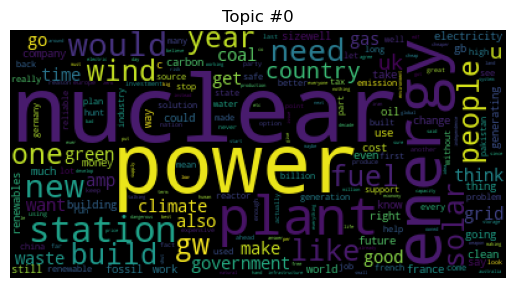

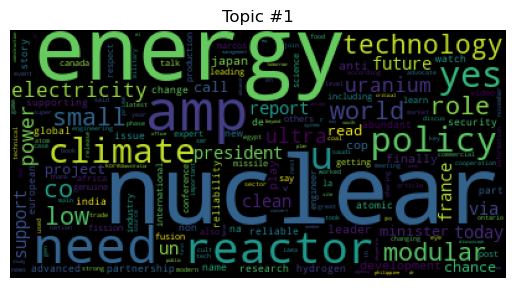

In [136]:
# word clouds
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

As seen here, there does not exist a clear difference in sentiment between the two topics. For example, Topic 0 contains the word “good”, and Topic 1 contains the good “yes”. Both word clouds also included negative words, such as “problem” in topic 0 and “issue” in topic 1. Given the inconsistency stemming from seeing both positive and negative words in both topics, we can conclude that LDA alone cannot identify a clear sentiment towards Nuclear Energy in either group.

What we decide to do, then is try to optimize our LDA model for use in another algorithm with a more distinct classification method, and see if this yields better results. In order to do this, we need to test our LDA model for the optimal number of topics to be used as vector dimensions. For LDA, there is no single objective method known to be best, but seeking out the maximum coherence scores seems to perform better than other metrics. We plot coherence scores across a range of LDA topic numbers below:

In [137]:
# perplexity and coherence scores

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_lemmatized, dictionary=dictionary , coherence='u_mass')
if __name__ == "__main__":
    #freeze_support()
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.5100677859901825

Coherence Score:  -3.5505514496909396


In [ ]:
#%% GRAPH FUNCTION

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# build list of scores across different topic numbers

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=corpus_lemmatized, start=2, limit=50, step=1)


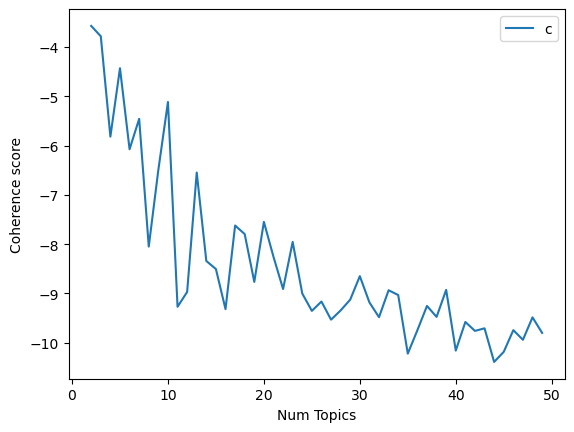

In [162]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Based on this graph, 2 topics appears to generate the highest coherence score for our LDA model, so we decide to stick with a 2 dimensional input into our classification algorithm with the topics as dimensions.

In [161]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 0  has Coherence Value of -3.5702
Num Topics = 1  has Coherence Value of -3.7804
Num Topics = 2  has Coherence Value of -5.8171
Num Topics = 3  has Coherence Value of -4.4289
Num Topics = 4  has Coherence Value of -6.0737
Num Topics = 5  has Coherence Value of -5.456
Num Topics = 6  has Coherence Value of -8.0493
Num Topics = 7  has Coherence Value of -6.4918
Num Topics = 8  has Coherence Value of -5.1139
Num Topics = 9  has Coherence Value of -9.272
Num Topics = 10  has Coherence Value of -8.9709
Num Topics = 11  has Coherence Value of -6.5466
Num Topics = 12  has Coherence Value of -8.3422
Num Topics = 13  has Coherence Value of -8.506
Num Topics = 14  has Coherence Value of -9.3199
Num Topics = 15  has Coherence Value of -7.6228
Num Topics = 16  has Coherence Value of -7.796
Num Topics = 17  has Coherence Value of -8.7672
Num Topics = 18  has Coherence Value of -7.5484
Num Topics = 19  has Coherence Value of -8.257
Num Topics = 20  has Coherence Value of -8.9112
Num Top

These topic distributions can also be visualized in the interactive element below. Good topic distributions will generate fairly large circles which do not overlap and are placed randomly in the plane. There are only two topics identified here, so placement in the plane can not take on any particular shape, but they do not appear to overlap. The word distributions and their assigned weights in the LDA model can be seen on the right when each topic circle is clicked:

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
vis_data = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.show(vis_data, open_browser=False, local=False)

For use in k-NN, we need to generate the 2-dimensional vectors for each tweet in the set. These vectors represent the topic probabilities LDA has assigned for each tweet. We do this below:

In [13]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

In [14]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

#%%

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

In [15]:
# Separating the sets again (training and labelled) to go into k-NN

labelled_lda = LDA_tweet_frame.iloc[:1175,:]
remainder_lda = LDA_tweet_frame.iloc[1175:,:]

#%%
labelled_lda = labelled_lda.join(labelled['label'])
#%%
labelled_lda.columns = ['Topic 0','Topic 1','label']

### Second Model: K-NN

The second model we will use to classify sentiment in our tweets is k-NN.

Since our two-topic LDA model does not seem suitable for sentiment classification on its own, we will use tweets vectorized by the LDA model as inputs for k-NN classification. We will then compare this to two k-NN models which use one-hot encoded sets of tweets, one which has been cleaned of usernames, symbols, non-English characters, stop words, and lemmatized, and another which leaves the tweets completely untouched.

In [16]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
import nltk
from sklearn.model_selection import train_test_split

In [17]:
# FOR LDA VECTORS:
train_data_lda = labelled_lda
test_data_lda = remainder_lda

LDA-BASED K-NN MODELING:

Our first job with k-NN is to use our labelled data set to test the model for accuracy. The LDA vectorized labelled set is fed into the algorithm here:

In [18]:
# %% for labelled_LDA_vectors and remainder_LDA_vectors
X = train_data_lda.iloc[:1175, :2]
y = train_data_lda.iloc[:1175, 2]

The labelled LDA vectors are then split into a 10% training and 90% validation set:

In [19]:
# %% Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=7)

In [20]:
# check the optimal k for KNN
def find_optimal_k(X_train,y_train,X_val,y_val):
    neighbors = np.arange(1, 20)
    train_accuracy = np.empty(len(neighbors))
    val_accuracy = np.empty(len(neighbors))
    # Loop over K values
    max_acc = 0
    optimal_k = 0
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        val_accuracy[i] = knn.score(X_val, y_val)
        if val_accuracy[i] > max_acc and i!=1:
            max_acc = val_accuracy[i]
            optimal_k = i

    # Generate plot
    plt.plot(neighbors, val_accuracy, label='Validation dataset Accuracy')
    plt.plot(neighbors, train_accuracy, label='Training dataset Accuracy')

    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()

    print("The optimal k is: ", optimal_k)
    return optimal_k

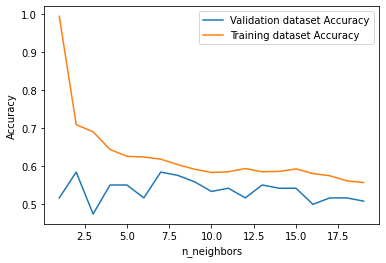

The optimal k is:  6


In [21]:
k = find_optimal_k(X_train,y_train,X_val,y_val)

After the k-NN algorithm is trained on the small subset of labelled tweets (plotted in orange), it classifies the validation set (plotted in blue), and the accuracy for both is output. The optimal number of neighbors is then identified for the labelled set, at k = 6. The confusion matrix for this trial is then output:

In [23]:
# %% Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score


def making_confusion_mat(X_train,y_train,X_val,y_val,optimal_k):
    # input: X_train,y_train,X_val,y_val and optimal_k
    classifier = KNeighborsClassifier(n_neighbors=optimal_k, metric='minkowski', p=2)
    classifier.fit(X_train, y_train)
    y_pred_val = classifier.predict(X_val)
    cm = confusion_matrix(y_val, y_pred_val)
    ac = accuracy_score(y_val, y_pred_val)
    
    # retun the confusion matrix, accuracy, and knn model
    return cm, ac, classifier, y_pred_val

In [24]:
res_lda = making_confusion_mat(X_train,y_train,X_val,y_val,k)
# output confusion matrix
res_lda[0]

array([[ 1,  5,  6],
       [ 4, 41, 16],
       [ 6, 20, 19]])

And the accuracy for the labelled set is output:

In [25]:
# output the accuracy corresponding to optimal k for validation data
print("The accuracy of validation set is: ", res_lda[1])

The accuracy of validation set is:  0.5169491525423728


K-NN RUN ON UNLABELLED SET OF LDA VECTORS

The next step is to try the k-NN algorithm as a sentiment label predictor on our unlabelled data, and compare its predicted label distribution to that of the pre-labelled distribution. It is input here:

In [26]:
# %% predict labels for test data
classifier = res_lda[2]
y_pred_test_lda = classifier.predict(test_data_lda.iloc[:,:])
y_pred_val_lda = res_lda[3]

In [27]:
# draw bar plots for distributions
def bar_plot(dataset, d_type):
    freq = np.array(np.unique(dataset, return_counts=True)).T
    freq_data = sorted(
                        [(name, float(val)) for name, val in freq],
                         key=lambda x:x[1],
                         reverse=True
                        )

    colors_list = ['Red', 'Orange', 'Blue']
    p1 = plt.bar(*zip(*freq_data), color=colors_list)

    n = len(dataset)
    for rect1 in p1:
        height = rect1.get_height()
        plt.annotate("{}%".format(round(height/n, 2)), (rect1.get_x() + rect1.get_width()/2,
                                            height+.05), ha="center", va="bottom", fontsize=15)
    
    # add title for plots    
    plt.title('Prediction results for '+ d_type)
    plt.show()

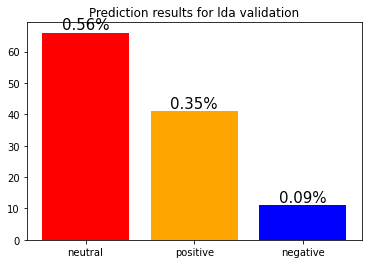

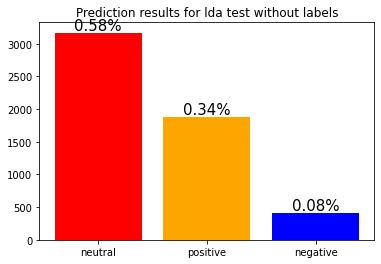

In [28]:
bar_plot(y_pred_val_lda, 'lda validation')  # bar plot for validation set for lda
bar_plot(y_pred_test_lda, 'lda test without labels')   # bar plot for test set for lda

The top bar plot represents the pre-labelled classification distribution, and the bottom plot represents the predicted label distribution. As you can see, the two trials have roughly similar distributions, with most tweets being classified as neutral sentiment, followed by positive sentiment, followed by negative sentiment. 

We now run the k-NN algorithm with raw word inputs, rather than LDA vectors. The first trial will be run with completely uncleaned tweets, encoded with one-hot encoding:

In [29]:
# define the one-hot encoding
def one_hot_encoding_tweets(data):
    # 1. create a CountVectorizer
    vec = CountVectorizer(tokenizer = nltk.word_tokenize)
    # convert the type of "tweets" to str
    data["tweets"] = data["tweets"].astype(str)
    tweet_list = list(data['tweets'])
    freq = vec.fit_transform(tweet_list)
    # create one-hot encoding
    ohot = Binarizer().fit_transform(freq)
    # one-hot encoding
    corpus_binary = ohot.todense()

    # convert matrix to dataframe
    encoder_df = pd.DataFrame(corpus_binary)

    # create x and y for knn
    x = encoder_df
    y = data['label']

    return x,y

In [30]:
# data_labelled: original tweets
# data_labelled_cleaned: cleaned version
data_labelled = labelled
data_labelled_cleaned = labelled_cleaned

In [31]:
# %% predict the results of test set
colnames = ['tweets']
data_test = remainder
data_test_cleaned = remainder_cleaned
data_test['label'] = ""
data_test_cleaned['label'] = ''

In [32]:
def merge_d(train_data, test_data):
    merge_data = train_data.append(test_data, ignore_index=True)

    # test the optimal k for the accuracy
    X = one_hot_encoding_tweets(merge_data)[0]
    y = one_hot_encoding_tweets(merge_data)[1]

    # Split into training and validation set and check the optimal k
    X_x = X.loc[:1174, :]
    y_y = y[:1175]

    X_train, X_val, y_train, y_val = train_test_split(
        X_x, y_y, test_size=0.1, random_state=0)
    
    # check the optimal k value
    k = find_optimal_k(X_train,y_train,X_val,y_val)
    
    # making confusion matrix
    res = making_confusion_mat(X_train,y_train,X_val,y_val, k)
    print("The confusion matrix for validation data is: \n", res[0])
    print("The accuracy of validation is: ", res[1])
    

    # predict labels of test data
    X_test = X.loc[1175:, :]
    classifier = res[2]
    y_pred_test = classifier.predict(X_test)
    y_pred_val = res[3]

    return merge_data, y_pred_test, y_pred_val

Once again, we check the model for accuracy by feeding the pre-labelled set (separated into 10% training and 90% validation) into the algorithm as well as identifing the optimal number of neighbors:

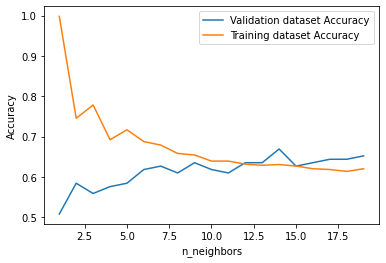

The optimal k is:  13
The confusion matrix for validation data is: 
 [[ 0  7  3]
 [ 0 58 11]
 [ 0 22 17]]
The accuracy of validation is:  0.635593220338983


In [33]:
res_uncleaned = merge_d(data_labelled, data_test)
y_pred_test_uncleaned = res_uncleaned[1]
y_pred_val_uncleaned = res_uncleaned[2]

In this case, the optimal number of neighbors is 15, and the validation model clocks in at an accuracy of roughly 64%.

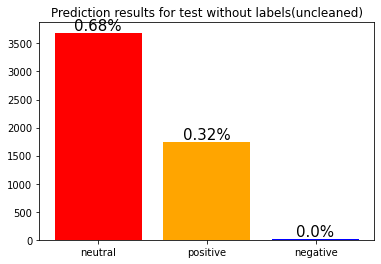

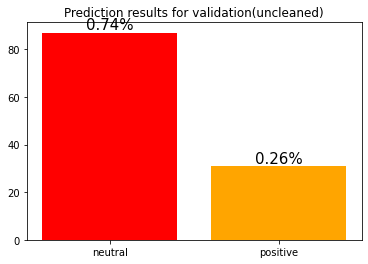

In [34]:
# prediction
bar_plot(y_pred_test_uncleaned,'test without labels(uncleaned)')
# 100% labelled
bar_plot(y_pred_val_uncleaned,'validation(uncleaned)')

Interestingly, the pre-labelled k-NN trial on completely raw uncleaned tweets shows exactly the same distribution as the pre-labelled LDA vector k-NN trial, but the prediction trial on the unlabelled uncleaned tweets classifies more tweets as neutral, less as positive, and none as negative.

Our final attempt at k-NN sentiment label classification is performed on tweets which have been cleaned of all usernames, punctuation, stopwords, and lemmatized. As before, we run the k-NN algorithm on our pre-labelled set to get an idea of its accuracy and optimal k number:

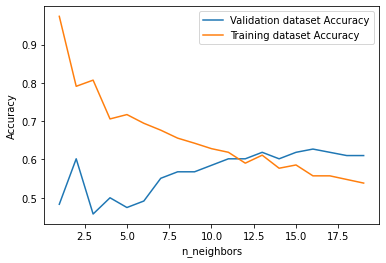

The optimal k is:  15
The confusion matrix for validation data is: 
 [[ 0  9  1]
 [ 0 67  2]
 [ 0 33  6]]
The accuracy of validation is:  0.6186440677966102


In [35]:
res_cleaned = merge_d(data_labelled_cleaned, data_test_cleaned)
y_pred_test_cleaned = res_cleaned[1]
y_pred_val_cleaned = res_cleaned[2]

Interestingly, 15 neighbors once again appears to be the optimal k, but this cleaned tweet k-NN model performs at a slighly lower accuracy than the uncleaned model at roughly 62%. Finally, we predict the sentiment labels for our unlabelled set of cleaned tweets and output their distributions below:

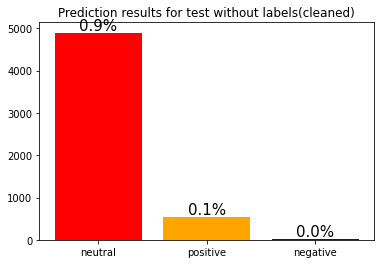

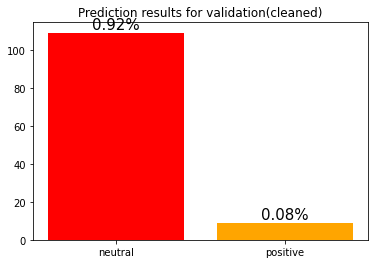

In [36]:
#predicted
bar_plot(y_pred_test_cleaned, 'test without labels(cleaned)')
#100% labelled
bar_plot(y_pred_val_cleaned, 'validation(cleaned)')

As can be seen here, the k-NN trial on the pre-labelled set of cleaned tweets outputs exactly the same sentiment distribution as that of the pre-labelled set of uncleaned tweets, but the prediction model of sentiment labels for the unlabelled cleaned tweets shows the highest distribution of tweets classified as neutral of all models, the lowest of all models classified as positive, and zero classified as negative.

Of the three k-NN models, we believe that the version which is run on the completely uncleaned set of tweets performs the best of all our k-NN models, due to its accuracy score. It's not a great accuracy score, but it does seem to be at least a little bit better than a coin toss!

### Third Model: VADER

In [65]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...


True

In [66]:
tokenized_words = word_tokenize(corpus_string, "english")
score = SentimentIntensityAnalyzer().polarity_scores(corpus_string)
score

{'neg': 0.103, 'neu': 0.691, 'pos': 0.206, 'compound': 1.0}

### Closing Statements: